# Explore Magnetron2_FRB Output
Let's take a look at what `magnetron2_FRB` actually returns. Using the priors for CHIME. 

In [88]:
import numpy as np
import matplotlib.pyplot as plt

In [89]:
datadir = "/home/mariska/UvA/magnetron2/data/"
res_dir = "/home/mariska/UvA/magnetron2/output/"

frb_name = "FRB20180725A_fake4"

### Loading data

In [90]:
data = np.loadtxt(f"{datadir}{frb_name}.dat")

time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]

### Loading results

See what the posterior looks like:

In [91]:
sample = np.loadtxt(f"{res_dir}{frb_name}/{frb_name}_posterior_sample.txt", skiprows=2)
nsamples = len(sample)
print(f"There are {nsamples} samples in the posterior")

There are 210 samples in the posterior


First, let's get out some of the global parameters: the background, and the hyperparameters for the prior distributions on the component amplitude, rise time, peak time and skewness parameter.
Sample (posterior_sample.txt) contains nsamples with each nsample (background parameter, burst dimensionality, number of model components, amplitude (hyper), sigma amplitude (hyper), etc.)

In [92]:
# def frb_params(sample):

# background parameter
bkg = sample[:,0]

# dimensionality of a single component
burst_dims =  sample[:,1]
burst_dims = list(set(burst_dims))[0]

# total number of model components permissible in the model
compmax = sample[:,2]
compmax = list(set(compmax))[0]

# hyper-parameter (mean) of the Gaussian distribution used
# as prior for the spike amplitudes
# NOTE: IN LINEAR SPACE, NOT LOG
hyper_mean_amplitude = sample[:,3]
hyper_sigma_amplitude = sample[:,4] # NOT IN CASE OF EXP AMPLITUDE PRIOR

# hyper-parameter (mean) for the exponential distribution used
# as prior for the spike rise time
# NOTE: IN LINEAR SPACE, NOT LOG
hyper_mean_risetime = sample[:,5]
hyper_sigma_risetime = sample[:,6]

# hyper-parameters for the lower and upper limits of the uniform
# distribution osed as a prior for the skew
hyper_lowerlimit_skew = sample[:,7]
hyper_upperlimit_skew = sample[:,8]

## distribution over number of model components
nbursts = sample[:, 9]
#print(nbursts)

# individual burst parameters for all 100 components
npos = sample[:,10:110] # peak position for all burst components
amp = sample[:,110:210] # amplitude for all burst components
scale = sample[:,210:310] # rise time for all burst components
skew = sample[:, 310:410] # skewness parameter for all burst components

# put all of the parameters together
pars_all = np.array([npos, amp, scale, skew]).T

# this is the 'endproduct': the flux of the model lightcurve 
# for every sample 
ymodel_all = sample[:,-len(time):] # model flux

    # return bkg, hyper_mean_amplitude, hyper_sigma_amplitude, hyper_mean_risetime, hyper_sigma_risetime, hyper_lowerlimit_skew, hyper_upperlimit_skew

Text(0.5, 1.0, 'skewness parameter upper limit')

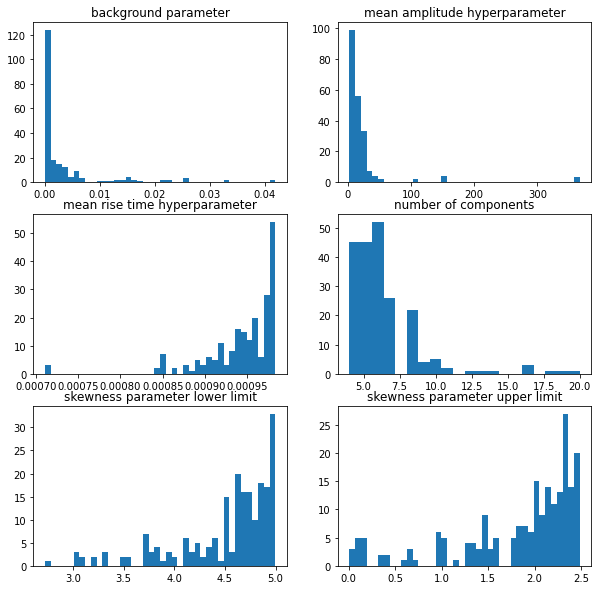

In [93]:
# def frb_hist(bkg, hyper_mean_amplitude, hyper_mean_risetime, nbursts, hyper_lowerlimit_skew, hyper_upperlimit_skew, nbins=40)   
nbins = 40

__, axes = plt.subplots(3,2, figsize=(10,10))
axes = np.hstack(axes)
axes[0].hist(bkg, bins=nbins, histtype="stepfilled")
axes[0].set_title("background parameter")

axes[1].hist(hyper_mean_amplitude, bins=nbins, histtype="stepfilled")
axes[1].set_title("mean amplitude hyperparameter")

axes[2].hist(hyper_mean_risetime, bins=nbins, histtype="stepfilled")
axes[2].set_title("mean rise time hyperparameter")

axes[3].hist(nbursts, bins=int(np.max(nbursts)), histtype="stepfilled")
axes[3].set_title("number of components")

axes[4].hist(hyper_lowerlimit_skew , bins=nbins, histtype="stepfilled");
axes[4].set_title("skewness parameter lower limit")

axes[5].hist(hyper_upperlimit_skew , bins=nbins, histtype="stepfilled");
axes[5].set_title("skewness parameter upper limit")

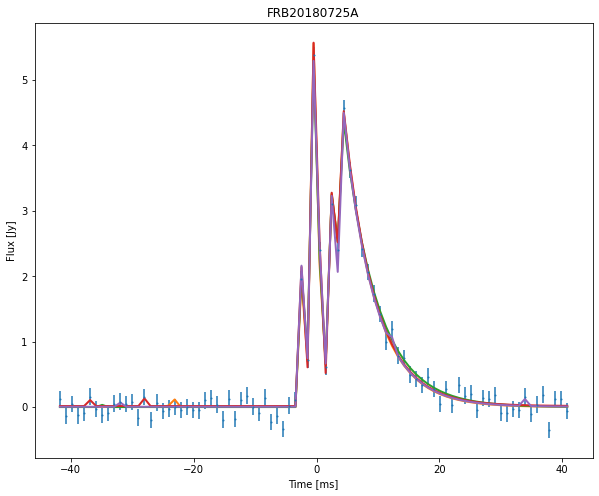

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))

ax.errorbar(time, flux, yerr=flux_err, fmt="o", markersize=1)

# The range indicates the amount of samples you plot below. 
for i in range(4):
    # Plot the model lightcurve for i samples 
    ax.plot(time, ymodel_all[i,:], lw=2)
    ax.set_title(frb_name.split("_")[0])
    ax.set_ylabel("Flux [Jy]")
    ax.set_xlabel("Time [ms]")

### Plotting components for a single posterior sample

For a single posterior sample, let's plot the individual components that make up the overall model for the burst light curve.

We'll just pick the first set of parameters in the posterior sample:

In [95]:
idx = 10 # index for the first posterior sample

n = nbursts[idx] # number of components in the burst
print("The number of components in this model is " + str(n))

pars = pars_all[:, idx, :] # get out all of the parameters for that model
pars = pars[:int(n),:] # I only need the parameters that are non-zero and correspond to real components
bkg_level = bkg[idx] # get background level for that model

The number of components in this model is 6e+00


Text(0.5, 0, 'Time [ms]')

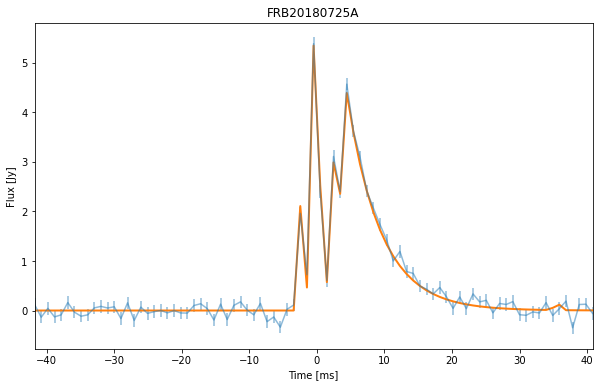

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.errorbar(time, flux, yerr=flux_err, alpha=0.5)

ymodel = ymodel_all[idx,:]

ax.plot(time, ymodel, lw=2)
ax.set_xlim(time[0], time[-1])
ax.set_title(frb_name.split("_")[0])
ax.set_ylabel("Flux [Jy]")
ax.set_xlabel("Time [ms]")

Let's make a function for the Fast-Rise, Exponential Decay (FRED) model that magnetron2 uses for the individual components.

In [97]:
def twoexp(time, theta, bkg_level):
    """ The function definition for a Fast-Rise Exponential-Decay (FRED) model. 

    Parameters:
    theta = list containing the peak position, amplitude, rise time 
    and skewness of the model lightcurve
    time = time series of the actual lightcurve  
    bkg_level = average level of the background noise (default: 0) 

    Returns: 
    Numpy-array of size len(self.times) with flux values. 
    """
    t0 = theta[0]
    amp = theta[1]
    scale = theta[2]
    skew = theta[3]
    
    t = (time - t0) / scale
    y = np.zeros_like(t)
    y[t <= 0] = np.exp(t[t <= 0]) 
    y[t > 0] = np.exp(-t[t > 0] / skew) 

    y = np.array(y)*amp + bkg_level

    return y

Text(0.5, 0, 'Time [ms]')

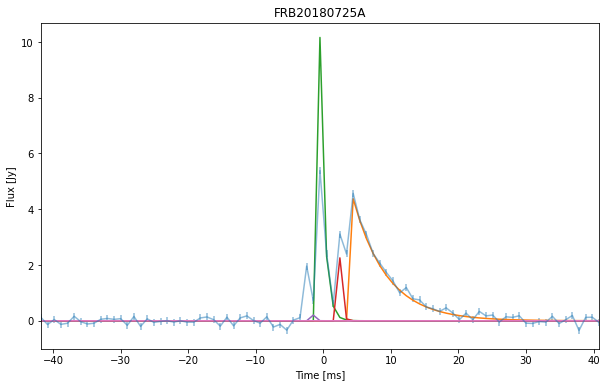

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

# plot the data
ax.errorbar(time, flux, yerr=flux_err, alpha=0.5)

# make an empty array for the total model fluxes
ymodel = np.zeros_like(time)

# loop over the components
for p in pars:
    # compute single component flux
    ytest = twoexp(time, p, bkg_level)
    
    # add component to the total flux
    ymodel += ytest
    
    # plot just the component
    ax.plot(time, ytest)

# set x-range
ax.set_xlim(time[0], time[-1])
ax.set_xlim(time[0], time[-1])
ax.set_title(frb_name.split("_")[0])
ax.set_ylabel("Flux [Jy]")
ax.set_xlabel("Time [ms]")

Let's zoom in on the large peak:

(-10.0, 10.0)

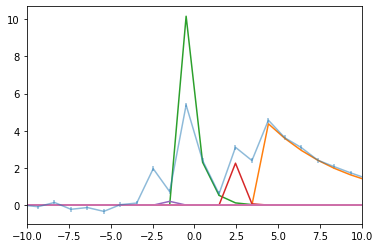

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

# plot the data
ax.errorbar(time, flux, yerr=flux_err, alpha=0.5)

# make an empty array for the total model fluxes
ymodel = np.zeros_like(time)

# loop over the components
for p in pars:
    # compute single component flux
    ytest = twoexp(time, p, bkg_level)
    
    # add component to the total flux
    ymodel += ytest
    
    # plot just the component
    ax.plot(time, ytest)

# set x-range
ax.set_xlim(-10, 10)